### Setup

This notebook explains how to to access the dataset models from django.
The datasets are loaded from the Postgres database into pandas dataframes.

To start the notebook server:

```
# Start a bash shell inside the api container
docker-compose exec api /bin/bash

# Start the jupyter notebook
python manage.py shell_plus --notebook

# Take note of the token provided and access the notebook through:
<ip-of-the-machine>:7777/?<token>
http://127.0.0.1:7777/?token=30c43675981e671b4a609cff470819098e274bbde415b7f5
```

This step has only to be made once as long as the jupyter-notebook keeps executing.
Considering that the the notebook continues to run, you can access the notebook using:
``` 
<ip-of-the-machine>:7777/?<token>
```

In [5]:
# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR
from django.contrib.auth.models import User

In [6]:
from api import adapters
from api import analysis

In [7]:

CAT_NEU_ANALYTES = [('Analytes', (
    ('USB', 'Antimony - Urine'),
    ('UTAS', 'Arsenic Total - Urine'), #modified just for poster - change back later/check if it's actually total 
    ('UBA', 'Barium - Urine'),
    ('UBE', 'Beryllium - Urine'),
    ('UCD', 'Cadmium - Urine'),
    ('UCS', 'Cesium - Urine'),
    ('UCR', 'Chromium - Urine'),
    ('UCO', 'Cobalt - Urine'),
    ('UCU', 'Copper - Urine'),
    ('UPB', 'Lead - Urine'),
    ('UMN', 'Manganese - Urine'),
    ('UHG', 'Mercury - Urine'),
    ('UMO', 'Molybdenum - Urine'),
    ('UNI', 'Nickel - Urine'),
    ('UPT', 'Platinum - Urine'),
    ('USE', 'Selenium - Urine'),
    ('UTL', 'Thallium - Urine'),
    ('USN', 'Tin - Urine'),
    ('UTU', 'Tungsten - Urine'),
    ('UUR', 'Uranium - Urine'),
    ('UVA', 'Vanadium - Urine'),
    ('UZN', 'Zinc - Urine')
    # Blood
    # ('BSB', 'Antimony - Blood'   ),
    # ('BTAS','Arsenic - Blood'    ),
    # ('BAL', 'Aluminum - Blood'   ),
    # ('BBE', 'Beryllium - Blood'  ),
    # ('BBA', 'Barium - Blood'     ),
    # ('BCD', 'Cadmium - Blood'    ),
    # ('BCS', 'Cesium - Blood'     ),
    # ('BCO', 'Cobalt - Blood'     ),
    # ('BCU', 'Copper - Blood'     ),
    # ('BCR', 'Chromium - Blood'   ),
    # ('BFE', 'Iron - Blood'       ),
    # ('BPB', 'Lead - Blood'       ),
    # ('BPB208','Lead (208) - Blood'),
    # ('BMB', 'Manganese - Blood'  ),
    # ('BHG', 'Mercury - Blood'    ),
    # ('BMO', 'Molybdenum - Blood' ),
    # ('BNI', 'Nickel - Blood'     ),
    # ('BPT', 'Platinum - Blood'   ),
    # ('BTL', 'Thallium - Blood'   ),
    # ('BTU', 'Tungsten - Blood'   ),
    # ('BUR', 'Uranium - Blood'    ),
    # ('BVA', 'Vanadium - Blood'   ),
    # ('BSE', 'Selenium - Blood'),
    # ('BSEG1124', 'Selenium+G1124 - Blood'),
    # ('BSN', 'Tin - Blood'        ),
    # ('BZN', 'Zinc - Blood'       ),
))]


CAT_DAR_ANALYTES = [('Analytes', (
    # Analyate acronym and name,                    Mapping in the dar DB
    ('UAG', ' Silver - Urine'),                     # Ag in ug/L
    ('UAL', ' Aluminium - Urine'),                  # Al in ug/L
    ('UCR',  'Chromium - Urine'),                   # Cr in ug/L
    ('UCU',  'Copper - Urine'),                     # Cu in ug/L
    ('UFE',  'Iron - Urine'),                       # Fe in ug/L
    ('UNI',  'Niquel - Urine'),                     # Ni in ug/L
    ('UVA',  'Vanadium - Urine'),                   # V in ug/L
    ('UZN',  'Zinc - Urine'),                       # Zn in ug/L
    # ('BCD',  'Cadmium - Blood'),
    # ('BHGE', 'Ethyl Mercury - Blood'),
    # ('BHGM', 'Methyl Mercury - Blood'),
    # ('BMN',  'Manganese - Blood'),
    # ('BPB',  'Lead - Blood'),
    # ('BSE',  'Selenium - Blood'),
    # ('IHG',  'Inorganic Mercury - Blood'),
    # ('THG',  'Mercury Total - Blood'),
    # ('SCU',  'Copper - Serum'),
    # ('SSE',  'Selenium - Serum'),
    # ('SZN',  'Zinc - Serum'),
    ('UAS3', 'Arsenous (III) acid - Urine'),        # As in ug/L
    # ('UAS5', 'Arsenic (V) acid - Urine'),
    ('UASB', 'Arsenobetaine - Urine'),              # AsB in ug/L
    # ('UASC', 'Arsenocholine - Urine'),
    ('UBA',  'Barium - Urine'),                     # Ba in ug/L
    ('UBE',  'Beryllium - Urine'),                  # Be in ug/L
    ('UCD',  'Cadmium - Urine'),                    # Cd in ug/L
    ('UCO',  'Cobalt - Urine'),                     # Co in ug/L
    ('UCS',  'Cesium - Urine'),                     # Cs in ug/L
    ('UDMA', 'Dimethylarsinic Acid - Urine'),       # DMA in ug/L
    ('UHG',  'Mercury - Urine'),                    # Hg in ug/L
    # ('UIO',  'Iodine - Urine'),
    ('UMMA', 'Monomethylarsinic Acid - Urine'),     # MMA in ug/L
    ('UMN',  'Manganese - Urine'),                  # Mn in ug/L
    ('UMO',  'Molybdenum - Urine'),                 # Mo in ug/L
    ('UPB',  'Lead - Urine'),                       # PB in ug/L
    # ('UPT',  'Platinum - Urine'),
    ('USB',  'Antimony - Urine'),                   # Sb in ug/L
    ('USN',  'Tin - Urine'),                        # Sn in ug/L
    ('USR',  'Strontium - Urine'),                  # Sr in ug/L
    ('UTAS', 'Arsenic Total - Urine'),              # iAs in ug/L
    ('UTL',  'Thallium - Urine'),                   # Tl in ug/L
    # ('UTMO', 'Trimethylarsine - Urine')
    ('UTU',  'Tungsten - Urine'),                   # W in ug/L
    ('UUR',  'Uranium - Urine'),                    # U in ug/L

))]

CAT_UNM_ANALYTES = [('Analytes', (
    ('BCD',  'Cadmium - Blood'),
    ('BHGE', 'Ethyl Mercury - Blood'),
    ('BHGM', 'Methyl Mercury - Blood'),
    ('BMN',  'Manganese - Blood'),
    ('BPB',  'Lead - Blood'),
    ('BSE',  'Selenium - Blood'),
    ('IHG',  'Inorganic Mercury - Blood'),
    ('THG',  'Mercury Total - Blood'),
    ('SCU',  'Copper - Serum'),
    ('SSE',  'Selenium - Serum'),
    ('SZN',  'Zinc - Serum'),
    ('UAS3', 'Arsenous (III) acid - Urine'),
    ('UAS5', 'Arsenic (V) acid - Urine'),
    ('UASB', 'Arsenobetaine - Urine'),
    ('UASC', 'Arsenocholine - Urine'),
    ('UBA',  'Barium - Urine'),
    ('UBE',  'Beryllium - Urine'),
    ('UCD',  'Cadmium - Urine'),
    ('UCO',  'Cobalt - Urine'),
    ('UCS',  'Cesium - Urine'),
    ('UDMA', 'Dimethylarsinic Acid - Urine'),
    ('UHG',  'Mercury - Urine'),
    ('UIO',  'Iodine - Urine'),
    ('UMMA', 'Monomethylarsinic Acid - Urine'),
    ('UMN',  'Manganese - Urine'),
    ('UMO',  'Molybdenum - Urine'),
    ('UPB',  'Lead - Urine'),
    ('UPT',  'Platinum - Urine'),
    ('USB',  'Antimony - Urine'),
    ('USN',  'Tin - Urine'),
    ('USR',  'Strontium - Urine'),
    ('UTAS', 'Arsenic Total - Urine'),
    ('UTL',  'Thallium - Urine'),
    ('UTMO', 'Trimethylarsine - Urine'),
    ('UTU',  'Tungsten -  Urine'),
    ('UUR',  'Uranium - Urine'),

))]


In [74]:
from api import adapters
from api import analysis
import pandas as pd

df_neu = adapters.neu.get_dataframe()  # [selected_columns]
df_unm = adapters.unm.get_dataframe()  # [selected_columns]
df_dar = adapters.dar.get_dataframe()  # [selected_columns]

df_neu = df_neu.replace(-9, np.nan).replace('-9', np.nan)
df_unm = df_unm.replace(-9, np.nan).replace('-9', np.nan)
df_dar = df_dar.replace(-9, np.nan).replace('-9', np.nan)

unm = [x[0] for x in CAT_UNM_ANALYTES[0][1]]
neu = [x[0] for x in CAT_NEU_ANALYTES[0][1]]
dar = [x[0] for x in CAT_NEU_ANALYTES[0][1]]

for analyte in unm:
    if analyte not in df_unm.columns:
        df_unm[analyte] = 0

main_idx = set(unm + neu + dar)

unm_har = []
neu_har = []
dar_har = []

for x in main_idx:
    if x in unm: 
        unm_har.append(1)
    elif x not in unm:
        unm_har.append(0)
    if x in neu: 
        neu_har.append(1)
    elif x not in neu:
        neu_har.append(0)
    if x in dar: 
        dar_har.append(1)
    elif x not in dar:
        dar_har.append(0)
        

df = pd.DataFrame({'UNM':unm_har, 'NEU':neu_har, 'DAR':dar_har }, index = main_idx)
df['sum'] = df.sum(axis = 1)

df_2 = df.sort_values(by = 'sum')[['UNM','NEU','DAR']]

#melted = pd.melt(df2, id_vars=['index'], value_vars=['unm','neu','dar'])

dff = pd.concat([df_neu,df_unm,df_dar])

print(dff.columns)
dff = dff[['CohortType']+ list(main_idx)]
dff_counts = dff.groupby(['CohortType']).count().transpose()
print('Counts&&&&&&')
print(dff_counts)



(570, 50)
(543, 10)
Model out 543. afterocnf 543. check ids 543
<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 0 to 542
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PIN_Patient         543 non-null    object 
 1   original            543 non-null    float64
 2   prediction          543 non-null    float64
 3   prediction_xvalue   543 non-null    float64
 4   original_xvalue     543 non-null    float64
 5   SPECIFICGRAVITY_V2  543 non-null    float64
 6   zscore              543 non-null    float64
 7   UDR                 543 non-null    float64
 8   Cohort              543 non-null    object 
 9   dil_indicator       543 non-null    int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 46.7+ KB
None
                    count      mean       std       min       25%       50%  \
original            543.0 -0.010786  1.007769 -2.651547 -0.707231  0.102901   
prediction       

In [75]:
df2.columns

Index(['PIN_Patient', 'TimePeriod', 'Member_c', 'Outcome', 'Outcome_weeks',
       'age', 'ethnicity', 'race', 'education', 'BMI', 'income', 'smoking',
       'parity', 'preg_complications', 'folic_acid_supp', 'fish', 'babySex',
       'birthWt', 'headCirc', 'birthLen', 'WeightCentile', 'LGA', 'SGA',
       'ga_collection', 'creatininemgdl_x', 'birth_year', 'UAS3', 'UAS5',
       'UASB', 'UASC', 'UDMA', 'UMMA', 'UPB', 'UTAS', 'CohortType', 'original',
       'prediction', 'prediction_xvalue', 'original_xvalue',
       'creatininemgdl_y', 'zscore', 'UDR', 'Cohort', 'dil_indicator'],
      dtype='object')

[Text(0, 0.5, 'DAR'), Text(0, 1.5, 'NEU'), Text(0, 2.5, 'UNM')]

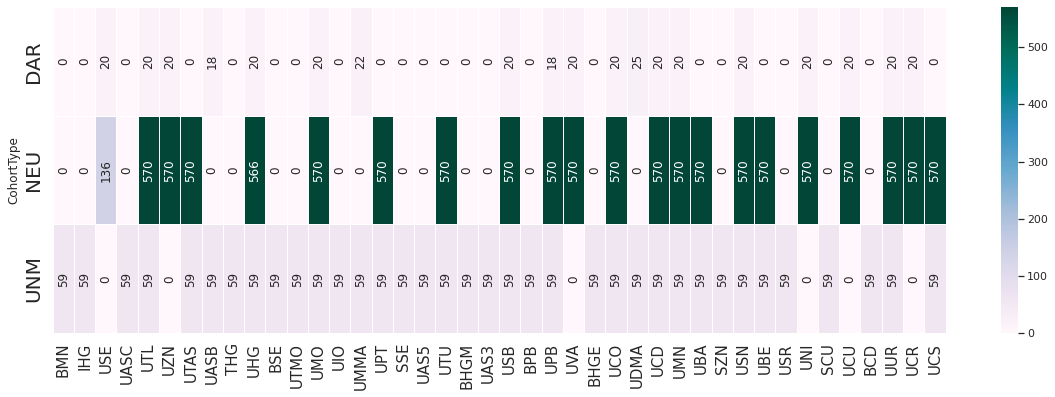

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 6))



df_counts = dff_counts.transpose()
masks = df2.transpose().drop(['CohortType'], axis = 0)

#assert df_counts.shape == masks.shape

res = sns.heatmap(df_counts, 
            annot=True, 
            cbar =True,
            fmt="d", 
            linewidths=1,
            annot_kws={'rotation':90},
            ax=ax,cmap="PuBuGn")

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 20)

In [ ]:
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [22]:
df2.transpose().shape

(4, 22)